# Neural style transfer

## Overview : 

In this notebook, we will learn how to change an image (the '*content*') with the style painting (aka '*style*').

This technique is mostly based on [Leon A. Gatys' paper, A Neural Algorithm of Artistic Style](https://arxiv.org/abs/1508.06576).

For this demonstration we will take a photo of a cat, and try to convert it into Mathilde Magne's art.

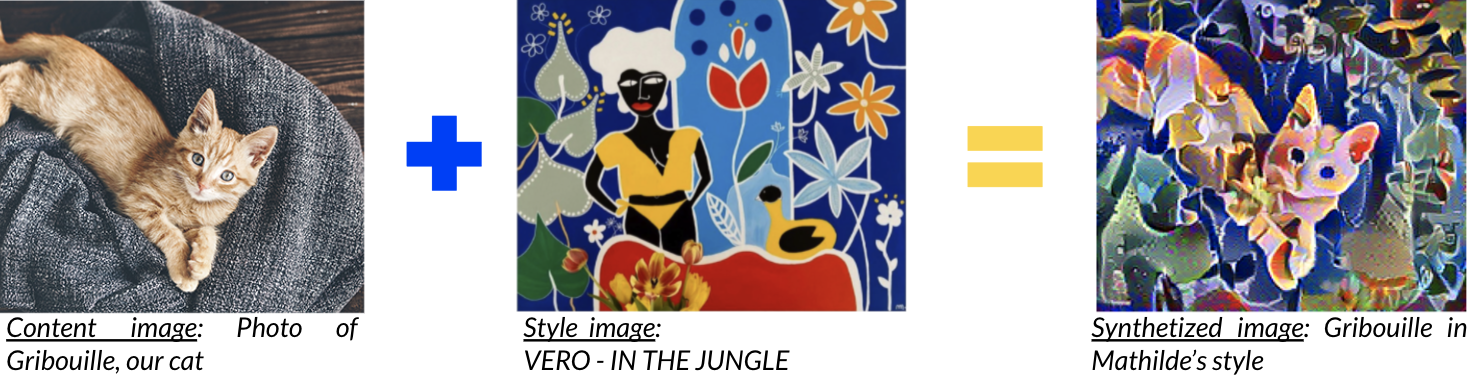

# Our understanding on the model



##Overview of the model at its architecture

During the style transfer, **only the synthetized image will be updated through the model**. 

**The goal of the model is to compare the synthetized image features vs. the content** (here in layer 2) **and vs. the style** (here in layer 1 and 3).

> A frozen CNN model (VGG16 or VGG19) is used to extract the image features at constant parameters. We will **choose the output of some layers as content features or style features**. 

> **During each run the image will adjust each pixels to optimize the synthetized image fitting with both the content and the style.**

*Starting point: The initialization of the model can either be a noise image, the content image or the style image.*

Forward propagation will be computing the loss functions while the backpropagation will update the synthetized image's weights.

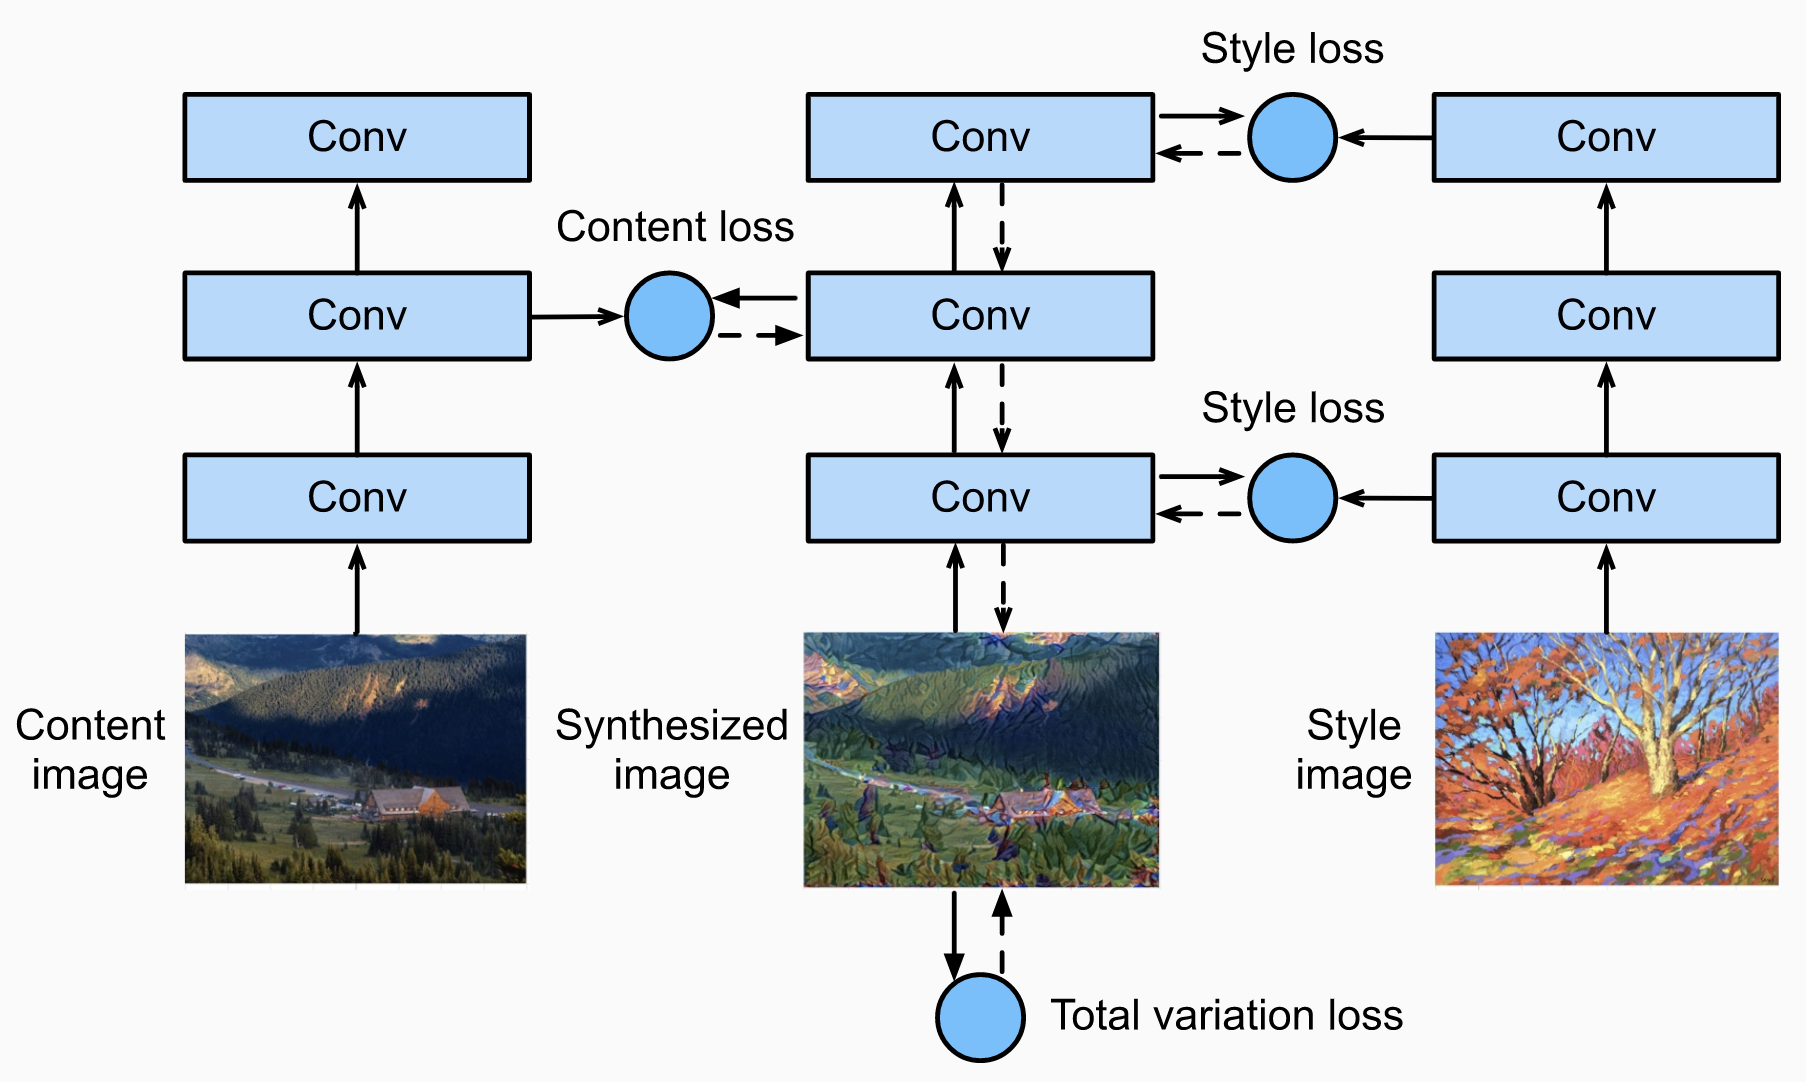

## Overview of the loss function

The principle of such model would be to try to minimizes two losses function at the same:


*   **Content Loss $L_{content}$**: the difference between the base image content and the final image content, and,
*   **Style Loss $L_{style}$**: the difference between the base style used and the final image style.



## Load data

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from google.colab import drive
import datetime
import os
drive.mount('/content/drive')

Mounted at /content/drive


First, let's define a function to **load the content and style images**.

In [2]:
from PIL.Image import open

def load_img():
    #data_path to raw_data to extract content & style images
    content_data_path = '/content/drive/My Drive/Artia on essecdrive/charles_style_transfer/dataset_style_transfer/content_chat.png'
    style_data_path = '/content/drive/My Drive/Artia on essecdrive/charles_style_transfer/dataset_style_transfer/style_landscape.png'
    
    content_name="".join(content_data_path.split('/')[-1].split('.')[0])
    style_name="".join(style_data_path.split('/')[-1].split('.')[0])
    
    _date=datetime.datetime.today().strftime("%m_%d")
    
    dir_path=f'/content/drive/My Drive/Artia on essecdrive/charles_style_transfer/data_gifs/stylized_{content_name}_{style_name}_{_date}'
    if not os.path.exists(dir_path):
      os.mkdir(dir_path)

    return {'content':content_data_path,'style':style_data_path,'directory':dir_path}

Let's print the **shape of image and content** images:

In [3]:
import tensorflow as tf
_tmp_content_viz=tf.io.read_file(load_img()['content'])
_tmp_content_viz=tf.image.decode_image(_tmp_content_viz,channels=3)
_tmp_style_viz=tf.io.read_file(load_img()['style'])
_tmp_style_viz=tf.image.decode_image(_tmp_style_viz,channels=3)

print(f"Content original shape & range =====> {_tmp_content_viz.shape}  & [{tf.reduce_min(_tmp_content_viz)}:{tf.reduce_max(_tmp_content_viz)}]")
print(f"Style original shape & range =====> {_tmp_style_viz.shape}  & [{tf.reduce_min(_tmp_style_viz)}:{tf.reduce_max(_tmp_style_viz)}]")

Content original shape & range =====> (300, 350, 3)  & [0:255]
Style original shape & range =====> (857, 1068, 3)  & [0:255]


## Scaling style & content

Define a function to :
  


*   **scale down** to a maximum dimension (512px) to the minimum of pixels between the content and the style and
*   normalize images


  
  

In [4]:
def img_to_tensor(path_to_img,max_dim=512):
  img = tf.io.read_file(path_to_img)                    #load data into tensor object
  img = tf.image.decode_image(img, channels=3)          #convert type of image (png,jpeg) into a single one with 3 channels (RGB) 
  img = tf.image.convert_image_dtype(img, tf.float32)   

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim                            #compute scale for tensor object

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)                 #resizing
  img = img[tf.newaxis, :]
  return img                                            #return image of shape (number of image, height in px, width in px, RGB)


Now we define a **style_tensor** and a **content_tensor** that will be the basis of our model.

In [5]:
style_tensor=img_to_tensor(load_img()['style'])
content_tensor=img_to_tensor(load_img()['content'])

print(f"Content scaled shape & range =====> {content_tensor.shape}  & [{tf.reduce_min(content_tensor)}:{tf.reduce_max(content_tensor)}]")
print(f"Style scaled shape & range   =====> {style_tensor.shape} & [{tf.reduce_min(style_tensor)}:{tf.reduce_max(style_tensor)}]")

Content scaled shape & range =====> (1, 438, 512, 3)  & [0.006070684175938368:1.0]
Style scaled shape & range   =====> (1, 410, 512, 3) & [0.0:0.9986456632614136]


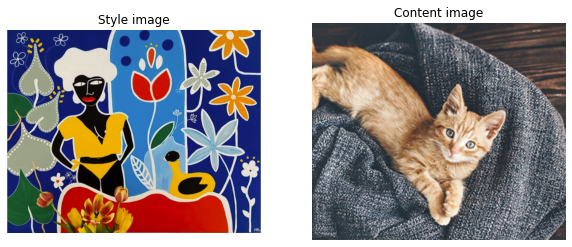

In [6]:
plt.figure(figsize=(10,10))

plt.subplot(1,2,1)
plt.title('Style image')
plt.axis('off')
plt.imshow(style_tensor[0])
plt.subplot(1,2,2)
plt.title('Content image')
plt.axis('off')
plt.imshow(content_tensor[0]);

Then, as a frozen [VGG19](https://keras.io/api/applications/vgg/vgg19-function) will be used for the Neutral Style Transfer (*it will be explained in the next section*), we will preprocess the images using the model on keras.

In [7]:
def VGG_preprocessing(image_tensor):
  x = tf.keras.applications.vgg19.preprocess_input(image_tensor*255)        #Calling VGG19 model on content_tensor
  x = tf.image.resize(x, (224, 224))                                        #Resizing to 224 images used by the VGG model
  return x

In [8]:
content_processed = VGG_preprocessing(content_tensor)
style_processed = VGG_preprocessing(style_tensor)

print(f"Content scaled shape & range =====> {content_processed.shape}  & [{tf.reduce_min(content_processed)}:{tf.reduce_max(content_processed)}]")
print(f"Style scaled shape & range   =====> {style_processed.shape} & [{tf.reduce_min(style_processed)}:{tf.reduce_max(style_processed)}]")

Content scaled shape & range =====> (1, 224, 224, 3)  & [-114.27135467529297:148.8065643310547]
Style scaled shape & range   =====> (1, 224, 224, 3) & [-123.68000030517578:148.27313232421875]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


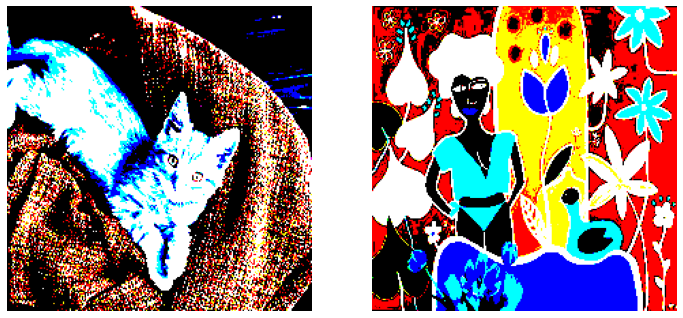

In [9]:
plt.figure(figsize=(12,12))

plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(content_processed[0])
plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(style_processed[0]);

### Define content and style representations
In order to get both the content and style representations of our image, we will **extract specific output from intermediate layers of the VGG19 model**. 

To do so, we will run content and style images into a frozen VGG19 model to extract the output of specific layers.

For layer selection, main principles are:

* for the content layer, a lower layer is used. Lower layer are better for capturing content representation as it will capture the objects and their arrangement in the input image. It corresponds to much more complex features than the higher ones. Hence, the nearer to the final layers of the CNN, the better the features.

* for the style layers, multiple layers will be used as different patterns need to be  detected. The first convolutional layer in each block of layers, that is, block1_conv1 up to block5_conv5 will be used.

  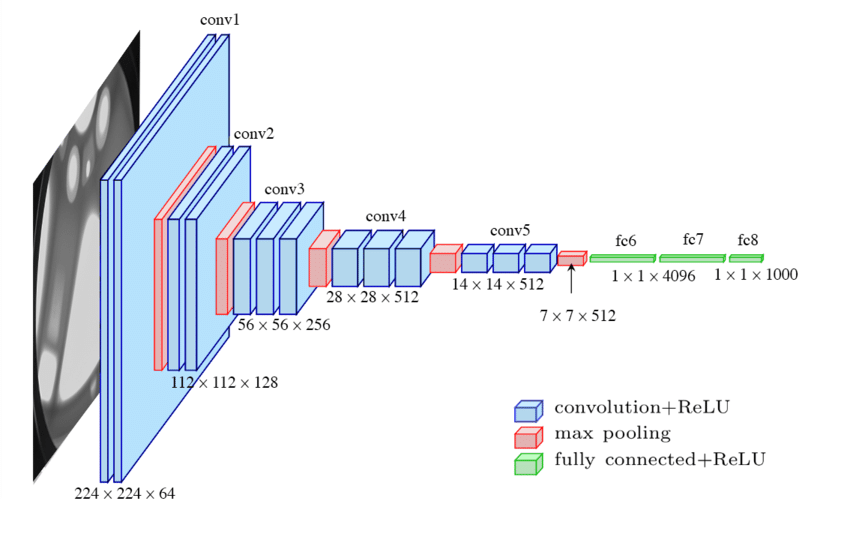

In [10]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

vgg.summary()

80150528/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

## Build the model 

Let's define a selection of intermediate layer outputs:

In [11]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

### Filters applied and their understanding

For a better understanding of the output selected, let's plot style & content filtered images:



In [46]:
def filter_vizualization(image_layers,image_processed,name):
  plt.figure(figsize=(20, 20))

  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  
  i=0
  column_to_display=4

  for layer in image_layers:
    layer_output = vgg.get_layer(layer).output  
    layer_model = tf.keras.models.Model(vgg.input, layer_output)
    layer_values = layer_model(image_processed)
    
    num_filters = layer_values.shape[-1]
    
    for j in range(column_to_display):
      plt.subplot(len(image_layers),column_to_display,j+i+1)
      plt.axis('off')
      plt.title(f"Filter {j}/{str(vgg.get_layer(layer).output.shape[-1])} in {layer}")
      plt.imshow(layer_values[0, :, :, j])
    i+=column_to_display



> **For the style first**



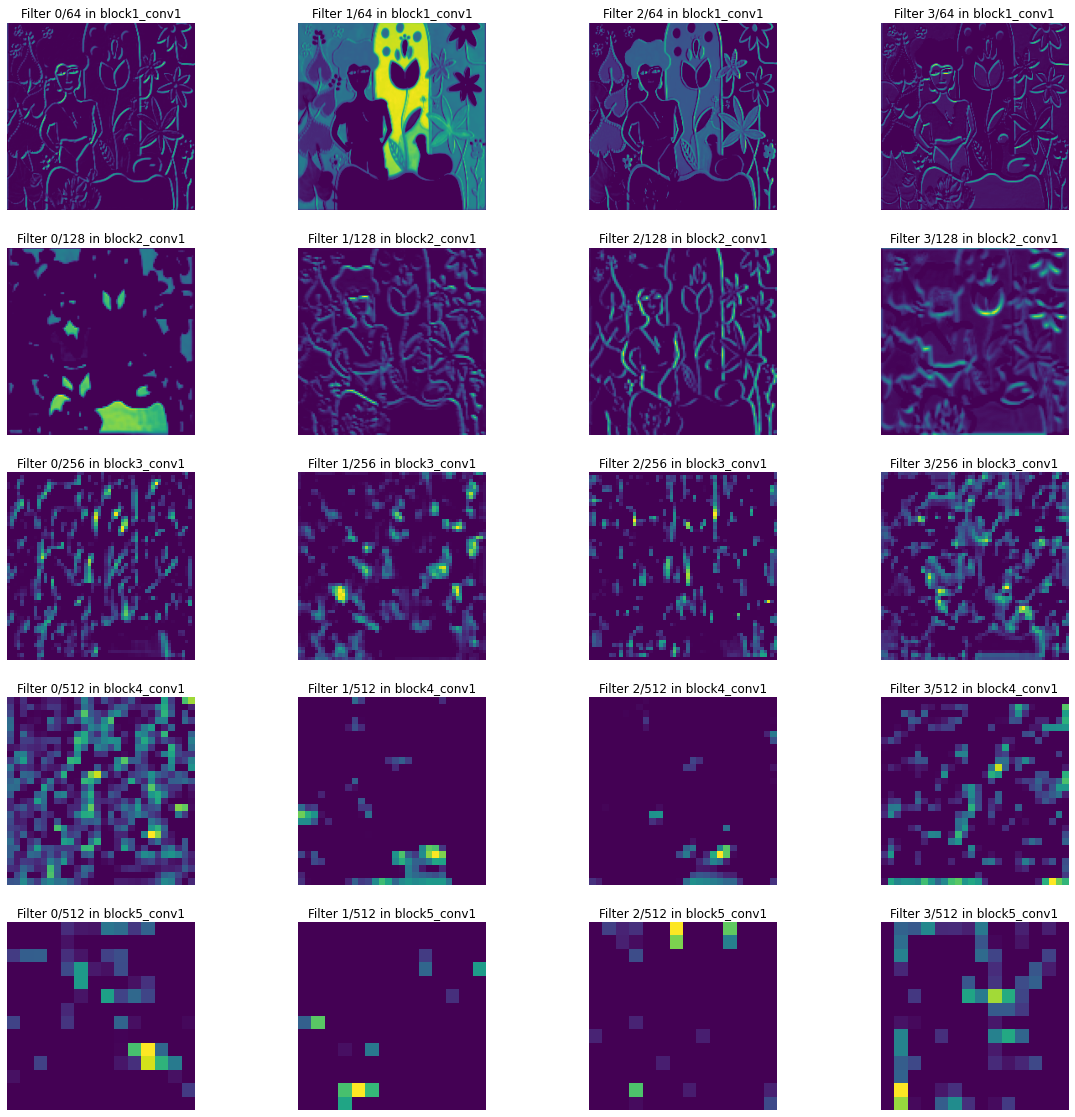

In [47]:
filter_vizualization(style_layers,style_processed,'style')



> **Now for the content**



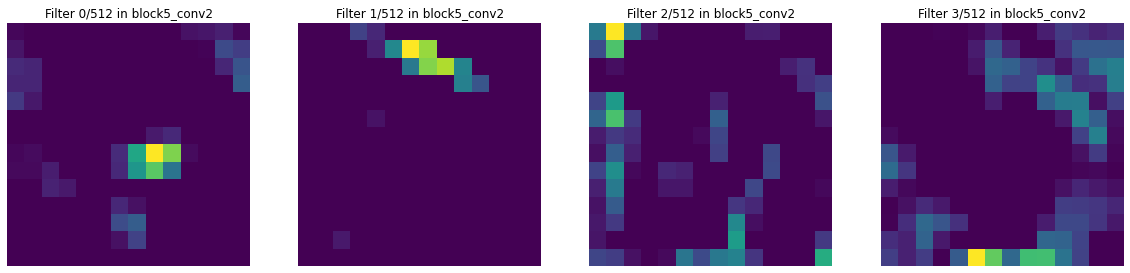

In [48]:
filter_vizualization(content_layers,content_processed,'content')

### Features extraction

Let's initialize a VGG19 model...

In [49]:
def vgg_layers():
  #Initialization of VGG19 model 
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  #Generate a list of layers outputs
  outputs = [layer_.output for layer_ in vgg.layers]

  #Generate a Model that will take an input (None,None,None,3) and generates 5 differents outputs
  model = tf.keras.Model(vgg.input, outputs)
  return model

... and define a function *output_extraction* that will extract outputs for given layers

In [50]:
def output_extraction(model,image_processed,image_layers=None):
  if image_layers:
    return {model.layers[index].name:output for index,output in enumerate(model(image_processed)) if model.layers[index].name in image_layers}    #Extract all {name:output} if not
  return {model.layers[index].name:output for index,output in enumerate(model(image_processed))}

In [51]:
style_outputs=output_extraction(vgg_layers(),style_processed,style_layers)
content_outputs=output_extraction(vgg_layers(),content_processed,content_layers)

As we previously visualized the filter, let's dive into key characteristics of each outputs.

In [52]:
def outputs_characteristics(model, image_processed,image_layers):
  image_outputs=output_extraction(model,image_processed,image_layers)        #Display all layers with outputs util the last output layer.
  
  for key,output in image_outputs.items():
    print(key)
    print("  shape: ", output.numpy().shape)
    print("  min: ", output.numpy().min())
    print("  max: ", output.numpy().max())
    print("  mean: ", output.numpy().mean())
    print()

> For the style

In [53]:
outputs_characteristics(vgg_layers(), style_processed,style_layers)

block1_conv1
  shape:  (1, 224, 224, 64)
  min:  0.0
  max:  760.022
  mean:  38.930042

block2_conv1
  shape:  (1, 112, 112, 128)
  min:  0.0
  max:  5237.5776
  mean:  231.41335

block3_conv1
  shape:  (1, 56, 56, 256)
  min:  0.0
  max:  10534.352
  mean:  312.0178

block4_conv1
  shape:  (1, 28, 28, 512)
  min:  0.0
  max:  22060.81
  mean:  1025.5355

block5_conv1
  shape:  (1, 14, 14, 512)
  min:  0.0
  max:  2651.7917
  mean:  74.163795



> For the content

In [54]:
outputs_characteristics(vgg_layers(), content_processed,content_layers)

block5_conv2
  shape:  (1, 14, 14, 512)
  min:  0.0
  max:  1709.7701
  mean:  23.387499



## Loss function and its minimization

As you probably noticed, our style transfer model will not be trained. It will compute the optimal weights of both the $L_{content}$ and $L_{style}$.

$L_{G} = \alpha L_{content}(C,P) + \beta L_{style}(S,P)$

Where:    


*   $L_{G}$ is the global loss;
*   $\alpha$ the weight of the content loss, $L_{content}$;
*   $\beta$ the weight of the content loss, $L_{style}$;
* C is the content image, S the style and P the '*prediction*' (generated image)



### Content loss

The content loss corresponds to the squared-loss error between the content and the target image.

$L_{content} = \frac1{n_l}Σ_{l}Σ_{i,j}(C_{i,j}^l -P_{i,j}^l)^2 $

Where:
* $^l$ & $_{i,j}$ a given layer and coordinates
* $C_{i,j}^l$ is the content image
* $P_{i,j}^l$ is the generated image

In [55]:
def content_loss(content_output, image_output):
    return tf.math.divide(tf.square(tf.add(content_output,-image_output)),2)

### Style loss

Not as easy as the content loss, the style loss corresponds to the squared-loss error between the gram matrices between the style image & the generated image.


$L_{style} = \frac12Σ_{l}Σ_{i,j}(\beta G_{i,j}^{s,l} -\beta G_{i,j}^{p,l})^2 $, or

$L_{style} = Σ_{l}w_lE_l$,  where

$E_{l} = \frac1{4N^2_lM^2_l}Σ_{i,j}(G_{i,j}^{s,l} -G_{i,j}^{p,l})^2 $, where


$G_{i,k}^l = (F^{l}(F^{l})^T)_{i,j}$

Where:
* $^l$ & $_{i,j}$ a given layer and coordinates
* $G_{i,j}^{s,l}$ is the Gram Matric for style image $^s$
* $G_{i,j}^{p,l}$ is the Gram Matric for the generated image $^p$
* $N_l$ is the number of filters within a layer
* $M_l$ is the size of each filter

#### Gram Matrix

The Gram Matrix corresponds to the inner product between the vertorized features map i and j in layer l representing the correlation between feature maps i and j.

$G_{i,k}^l = Σ_{k}F_{i,k}^{l}F_{j,k}^{l}$  

or

$G_{i,k}^l = (F^{l}(F^{l})^T)_{i,j}$

Where:
* $^l$ & $_{i,j}$ a given layer and coordinates
* $G_{i,j}^{s,l}$ is the Gram Matric for style image $^s$
* $G_{i,j}^{p,l}$ is the Gram Matric for the generated image $^p$

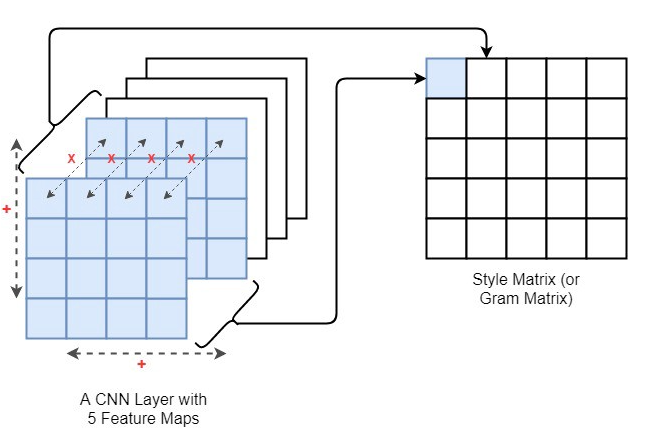

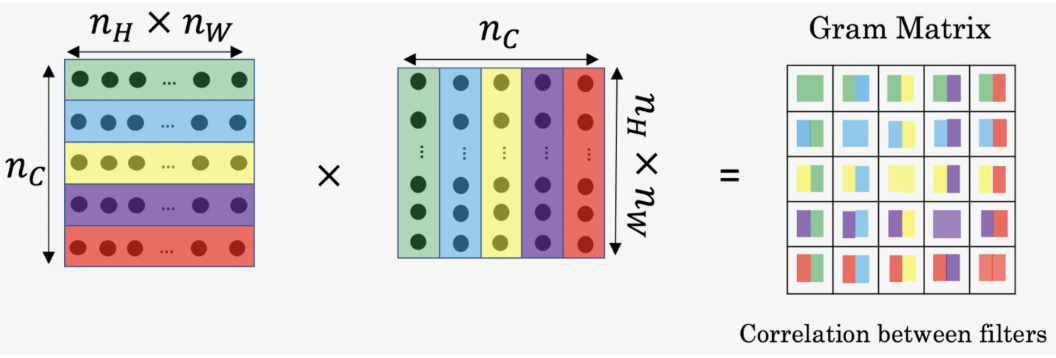

## Ok for the maths. But why ?

The idea behind the Gram matrix is to capture, for a given layer, the distribution of the feature maps.

Hence, the style loss function $L_{style}$ will allow us to match the distribution of features between the synthetized image and its style target.

> For example, consider two vectors representing map features within a layer, and **their dot product give us the information about the relation between them**. 

> The lesser the product the more different the learned features are and greater the product, the more correlated the features are. 

> In other words, the lesser the product, the lesser the two features co-occur and the greater it is, the more they occur together. 

This in a sense gives information about an image’s style and zero information about its spatial structure, since we already flatten the feature and perform dot product on top of it. The goal is to capture abstract style, not position.



In [56]:
def gram_matrix(image_output):
    """
    Computation of the gram matrix from the outputs of the model.
    Initial object is of shape (1,px,px,channels), we convert it into
    a transposable matrix of dim (1*px*px,channels) and finally
    we compute the X.X^T
    """
    n_channels = image_output.shape[-1]
    n_size=image_output.shape[1]**2
    transposable_matrix = tf.reshape(image_output, [-1, n_channels])
    style_matrix = tf.matmul(transposable_matrix, transposable_matrix, transpose_a=True)
    return style_matrix

In [57]:
def style_loss(style_output,image_output):
    gram_style=gram_matrix(style_output)
    gram_image=gram_matrix(image_output)
    N=style_output.shape[-1]**2                                 #squared number of layers
    M=(style_output.shape[1]**2)**2                             #squared filter dimension
    return tf.reduce_sum((tf.square(tf.add(gram_style,-gram_image))))/(4*N*M)

In [58]:
def compute_loss(style_output,content_output,image_output,style_weight=1e-2,content_weight=1e4):

  content_l=tf.reduce_sum([content_loss(content_output[key], image_output[key])/len(content_output.keys()) for key in content_output.keys()])

  style_l=tf.reduce_sum([style_loss(style_output[key],image_output[key])/len(style_output.keys()) for key in style_output.keys()])

  total_l=style_weight*style_l+content_weight*content_l

  return {'style_loss':style_l,'content_loss':content_l,'total_loss':total_l}

## Total variation loss

One drawback of the above methode is that it has a lot of high-frequencyh noise, i.e., extra bright or dark pixes (or lines).

We used a noise reduction methode, that is the total variation denoising:

$L_{denoising}=\Sigma_{i,j} |x_{i,j} - x_{i+1,j}| + |x_{i,j} - x_{i,j+1}|$

In [59]:
def denoising_loss(image,denoising_weight=1):
  x_var = tf.reduce_sum(tf.abs(image[:, 1:, :, :] - image[:, :-1, :, :]))
  y_var = tf.reduce_sum(tf.abs(image[:, :, 1:, :] - image[:, :, :-1, :]))

  return denoising_weight*0.5*(x_var+y_var)

## Run gradient descent

With this style and content extractor, you can now implement the style transfer algorithm. Do this by calculating the mean square error for your image's output relative to each target, then take the weighted sum of these losses.

Set your style and content target values:

In [60]:
content_targets = content_outputs.copy()

In [61]:
style_targets=style_outputs.copy()

Define a `tf.Variable` to contain the image to optimize. 

To make this quick, initialize it with the content image (the `tf.Variable` must be the same shape as the content image):

In [62]:
image = tf.Variable(content_tensor)

Create an optimizer. The paper recommends LBFGS, but `Adam` works okay, too:

In [63]:
opt = tf.optimizers.Adam(learning_rate=0.002, beta_1=0.99, epsilon=1e-2)

Use `tf.GradientTape` to update the image.

Since it's working, let's perform a longer optimization:

In [64]:
content_targets = content_outputs.copy()
style_targets = style_outputs.copy()
image = tf.Variable(content_tensor)
opt = tf.optimizers.Adam(learning_rate=9.5e-3, beta_1=99e-2, epsilon=1e-1)

In [65]:
model=vgg_layers()
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:

    image_processed=VGG_preprocessing(image)
    image_output=output_extraction(model,image_processed,style_layers+content_layers)
    loss = compute_loss(style_targets,content_targets,image_output,style_weight=1e2,content_weight=7.5e0)['total_loss']
    loss+=denoising_loss(image_processed,2e2)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(tf.clip_by_value(image,0.0,1.0))

....

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reus

................................................................................................

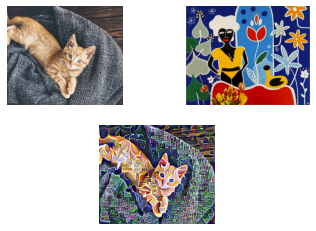

Train step: 100
....................................................................................................

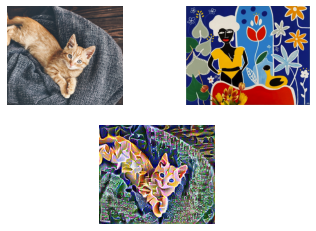

Train step: 200
....................................................................................................

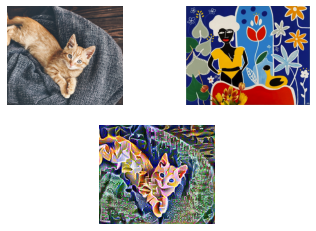

Train step: 300
....................................................................................................

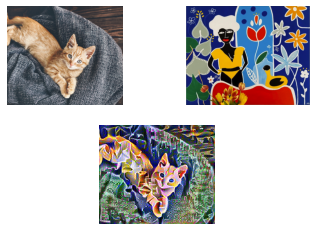

Train step: 400
....................................................................................................

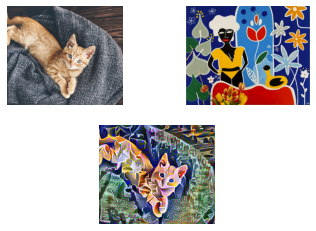

Train step: 500
....................................................................................................

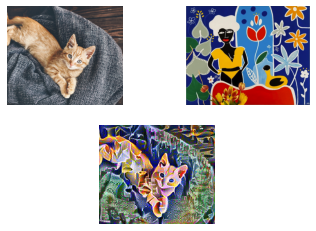

Train step: 600
....................................................................................................

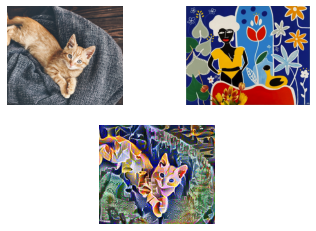

Train step: 700
....................................................................................................

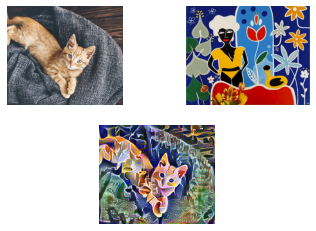

Train step: 800
....................................................................................................

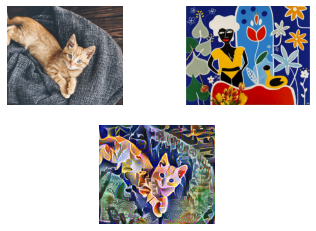

Train step: 900
....................................................................................................

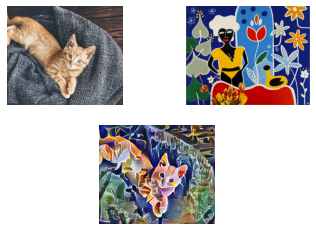

Train step: 1000
Total time: 185.5


In [66]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
    plt.subplot(2,2,1)
    plt.axis('off')
    plt.imshow(content_tensor[0])
    plt.subplot(2,2,2)
    plt.axis('off')
    plt.imshow(style_tensor[0])
    plt.subplot(2,2,(3,4))
    plt.axis('off')
    plt.imshow(image[0])
  plt.show()
  print("Train step: {}".format(step))
  
end = time.time()
print("Total time: {:.1f}".format(end-start))

In [67]:
import PIL.Image
import numpy as np

def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [68]:
import tensorflow_hub as hub

model = hub.load("https://tfhub.dev/captain-pool/esrgan-tf2/1")
fake_image = model(image*255)

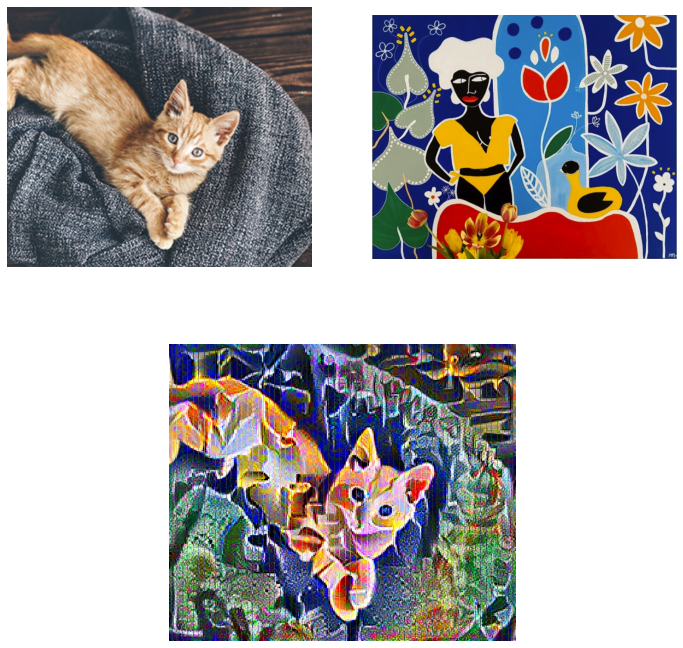

In [73]:
version='vFinal'

plt.figure(figsize=(12,12))

plt.subplot(2,2,1)
plt.axis('off')
plt.imshow(content_tensor[0])
plt.subplot(2,2,2)
plt.axis('off')
plt.imshow(style_tensor[0])
plt.subplot(2,2,(3,4))
plt.axis('off')
plt.imshow(fake_image[0]/255)
plt.show()

Finally, save the result:

In [ ]:
version='vFinal'
file_name = f"load_img()['directory']/high_quality_{version}"
tensor_to_image(image).save(file_name)

In [ ]:
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(file_name)